In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules

from Bio import SeqIO
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(1)
torch.manual_seed(1)

### Paths

In [3]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

### Get metadata

In [4]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


In [5]:
metadata["merged"] = metadata["CDR3a"] + metadata["CDR3b"]

In [12]:
outfile = open("cdr3_seqs.fsa", "w")
for x, i in zip(list(metadata["merged"]), list(metadata.index)):
    string = f">{i}\n{x}"
    print(string, file=outfile)
outfile.close()

In [113]:
cluster_path = "/home/sebastian/masters/data/neat_data/clusterRes_cluster.tsv"

def K_fold_CV_from_clusters(cluster_path, n_split=5):
    """loads clusters from mmseqs2 clustering tsv formatted results"""
    clusters = dict()
    with open(cluster_path) as file:
        for line in file:
            line = line.strip()
            line = line.split("\t")
            cluster_id = int(line[0])
            seq_id = int(line[1])
            if cluster_id not in clusters:
                clusters[cluster_id] = [seq_id]
            else:
                clusters[cluster_id].append(seq_id)

    clusters_list = list(clusters.values())
    clusters_list.sort(key=len)

    partitions = [list() for _ in range(n_split)]
    
    # round robin balancing of partitions
    i = 0
    for seq_idx in clusters_list:
        partitions[i].extend(seq_idx)
        i += 1
        if i >= n_split:
            i = 0        

    train_partitions = [list() for _ in range(n_split)]
    test_partitions = [list() for _ in range(n_split)]

    for i in range(len(partitions)):
        test_partitions[i] = partitions[i]
        for j in range(len(partitions)):
            if j != i:
                train_partitions[i].extend(partitions[j])

    return train_partitions, test_partitions

train_partitions, test_partitions = K_fold_CV_from_clusters(cluster_path)

In [115]:
CV = KFold(n_splits=5, shuffle=True)


<generator object _BaseKFold.split at 0x7f8963ab0dd0>

In [116]:
for x, y in CV.split(train_partitions[0]):
    print(len(x), len(y))

6528 1633
6529 1632
6529 1632
6529 1632
6529 1632


In [110]:
2149+1937+2031+2044

8161

In [108]:
len(train_partitions[0])

8161

In [109]:
len(test_partitions[0])

2170

In [89]:
len(train_part)

4

In [72]:
len(partitions[])

2044

In [57]:
len(test_part)

2149

In [58]:
len(train_part)

2170

### Make GNN embeddings

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

raw_files = np.array(metadata["path"])
targets = np.array(metadata["binder"])

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)

In [7]:
def create_gnn_embeddings(
    dataset, 
    out_dir, 
    device, 
    gnn_func, 
    cores=1, 
    overwrite=False, 
    chain_keys=np.array(["P", "M", "A", "B"])
):  
    def _sub_process(out_path, data, chain_keys=chain_keys, gnn_func=gnn_func):
        #data = data.to("cpu")
        with torch.no_grad():
            out = gnn_func(data.x, data.edge_index, data.edge_attr)

        # add positional encoding of chains
        positional_encoding = np.zeros((len(data.x), len(chain_keys)))
        for j, p in enumerate(data.chain_map[0]):
            positional_encoding[j][np.where(chain_keys == p)] = 1
        positional_encoding = torch.Tensor(positional_encoding)
        out = torch.cat((out, positional_encoding), dim=1)

        torch.save(out, out_path)

    out_dir.mkdir(mode=0o775, parents=True, exist_ok=True)
    
    data_loader = torch_geometric.loader.DataLoader(dataset, shuffle=False, batch_size=1)
    out_files = list()
    targets = list()
    for i, data in enumerate(data_loader):
        out_path = out_dir / f"data_{i}.pt"
        if not out_path.is_file() or overwrite:
            out_files.append(out_path)
        targets.append([data.y])
    torch.save(targets, out_dir / f"targets.pt")

    #sub_process = lambda out_path, data: _sub_process(
    #    out_path,
    #    data,
    #    gnn_func=gnn_func,
    #    chain_keys=chain_keys,
    #)
    #args = zip(out_files, data_loader)
    #Parallel(n_jobs=cores)(delayed(_sub_process)(*arg) for arg in args)
    for arg in zip(out_files, data_loader):  # use instead of failed attempt at parallelizing pytorch stuff
        _sub_process(*arg)

gnn_func = gnn.forward_without_last_layer
processed_out_dir = processed_dir / "gnn_out_pos_128"
#create_gnn_embeddings(dataset, processed_out_dir, device, gnn_func, cores=4, overwrite=False)
#create_gnn_embeddings(dataset, processed_out_dir, device, gnn_func, overwrite=False)

### Get indices of CDR3 residues

In [ ]:
def find_subset_idx(seq, subset_seq):
    subset_indices = list()
    subset_len = len(subset_seq)
    for i in range(len(seq) - subset_len + 1):
        if np.all(seq[i : i + subset_len] == subset_seq):
            return [i, i + subset_len]

new_out_dir = processed_dir / "cdr_and_peptide_only"
new_out_dir.mkdir(mode=0o775, parents=True, exist_ok=True)

chain_keys = np.array(["P", "M", "A", "B"])
full_seq_path = data_root / "full_seqs.fsa"

cdr3a_indices = list()
cdr3b_indices = list()

for i, record in enumerate(SeqIO.parse(full_seq_path, "fasta")):
    seq = np.array(list(record.seq))
    
    data = dataset[i]
    x = torch.load(out_dir / f"data_{i}.pt")
    metadata_row = metadata.iloc[i]
    
    new_data = list()
    for cdr3, tcr in [["CDR3a", "A"], ["CDR3b", "B"]]:
        # get TCR and CDR3 seq
        tcr_seq = seq[np.where(data.chain_map == tcr)]
        cdr3_seq = np.array(list(metadata_row[cdr3]))
        
        # find indices of CDR3 in TCR
        start_idx, end_idx = find_subset_idx(tcr_seq, cdr3_seq)
        
        # slice embedded data to correct chain using pos encoding and subset CDR indices
        pos_encoding_key = np.where(chain_keys == tcr)[0][0] - 4 # subtract 4 to get same key as when data was generated
        cdr3_embed = x[x[:, pos_encoding_key] == 1]  
        cdr3_embed = cdr3_embed[start_idx:end_idx]
        new_data.append(cdr3_embed)
    
    pos_encoding_key = np.where(chain_keys == "P")[0][0] - 4
    peptide_embed = x[x[:, pos_encoding_key] == 1]
    new_data.append(peptide_embed)
    new_data = torch.vstack(new_data)
    torch.save(new_data, new_out_dir / f"data_{i}.pt")
    

### Make LOO partitions and init dataset

In [8]:
unique_peptides = metadata["peptide"].unique()

metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]
loo_train_partitions = list()
loo_valid_partitions = list()
for pep in unique_peptides:
    valid_df = metadata[metadata["peptide"] == pep]
    valid_unique_cdr = valid_df["merged_chains"].unique()
    
    # get training rows and drop swapped data
    train_df = metadata[metadata["peptide"] != pep]
    train_df = train_df[~train_df["merged_chains"].str.contains('|'.join(valid_unique_cdr))]

    loo_train_partitions.append(list(train_df.index))
    loo_valid_partitions.append(list(valid_df.index))

dataset = LSTMDataset(
    data_dir=processed_dir / "cdr_and_peptide_only", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

# hacky dataset fix
# hacky dataset fix
# hacky dataset fix
filtered_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
filtered_indices = list()
filtered_partitions = list()

for pep in filtered_peptides:
    filtered_indices.extend(list(metadata[metadata["peptide"] == pep].index))
    filtered_partitions.extend(np.where(unique_peptides == pep)[0])

loo_train_partitions = [part for i, part in enumerate(loo_train_partitions) if i not in filtered_partitions]
loo_valid_partitions = [part for i, part in enumerate(loo_valid_partitions) if i not in filtered_partitions]

filtered_indices = set(filtered_indices)

for i in range(len(loo_train_partitions)):
    train_part, valid_part = loo_train_partitions[i], loo_valid_partitions[i]
    train_part = [i for i in train_part if i not in filtered_indices]
    valid_part = [i for i in valid_part if i not in filtered_indices]
    loo_train_partitions[i], loo_valid_partitions[i] = train_part, valid_part
    
unique_peptides = np.delete(unique_peptides, filtered_partitions)

In [9]:
for x in [(len(x), len(y), len(x)+len(y)) for x,y in zip(loo_train_partitions, loo_valid_partitions)]:
    print(x)

(8381, 1217, 9598)
(10214, 70, 10284)
(10174, 87, 10261)
(10017, 201, 10218)
(10253, 39, 10292)
(10236, 54, 10290)
(10182, 89, 10271)
(10169, 86, 10255)
(9946, 217, 10163)
(10262, 34, 10296)
(9917, 245, 10162)
(7613, 1667, 9280)
(10192, 76, 10268)
(2011, 6223, 8234)
(10306, 8, 10314)
(10308, 7, 10315)


### LSTM

In [10]:
class TripleLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout=0.0):
        super(TripleLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        
        self.lstm_1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )       
        self.lstm_2 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )        
        self.lstm_3 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout, 
            batch_first=True,
        )     

        self.linear_dropout = nn.Dropout(p=dropout)
        self.batch_norm = nn.BatchNorm1d(num_features=hidden_dim)
        self.linear_1 = nn.Linear(hidden_dim * 3, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)
        
        torch.nn.init.xavier_uniform_(self.linear_1.weight)
        torch.nn.init.xavier_uniform_(self.linear_2.weight)
    
    def forward(self, x_1, x_2, x_3):
        _, (h_1, _) = self.lstm_1(x_1)
        _, (h_2, _) = self.lstm_2(x_2)
        _, (h_3, _) = self.lstm_3(x_3)
        h_cat = torch.cat((h_1[-1], h_2[-1], h_3[-1]), dim=1)
        out = self.linear_1(h_cat)
        out = self.batch_norm(out)
        out = F.relu(out)
        out = self.linear_dropout(out)
        out = self.linear_2(out)
        return out

    
def pad_collate_chain_split_cdr(batch, pad_val=0, n_split=4, drop_idx=None):
    (xx, yy) = zip(*batch)
    x_split_batch = [list() for _ in range(n_split)]
    for x in xx:
        for i in range(n_split):
            x_split_batch[i].append(x[x[:,-i - 1] == 1][:,:-n_split])  # slice based on positional encoding and remove encoding part
    
    for i in range(n_split):
        x_split_batch[i] = nn.utils.rnn.pad_sequence(
            x_split_batch[i], 
            batch_first=True, 
            padding_value=pad_val
        )

    if drop_idx is not None:
        del x_split_batch[drop_idx]
    
    yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
    return x_split_batch, yy_pad

### LOO training scheme

In [ ]:
from functools import partial

# LSTM params
batch_size = 64
embedding_dim = 128
hidden_dim = 64 #32
num_layers = 2  # from 2
epochs = 20
learning_rate = 1e-3
lr_decay = 0.95 #TODO set some val, 1=no effect
w_decay = 1e-4
dropout = 0.8  # test scheduled dropout. Can set droput using net.layer.dropout = 0.x https://arxiv.org/pdf/1703.06229.pdf

# touch files to ensure output
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

# extra stuff
extra_print_str = "\nSaving to {}\nFold: {}\nPeptide: {}"
drop_idx = np.where(chain_keys == "M")[0][0] + 1 # drop data for MHC chain

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    
    net = TripleLSTM(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        dropout=dropout,
    )
    net = net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=learning_rate, 
        #weight_decay=w_decay,
    )  # test learning rate scheduler to reduce validation volatility
    scheduler = optim.lr_scheduler.MultiplicativeLR(
        optimizer, 
        lr_lambda=lambda epoch: lr_decay
    )
    
    net, train_losses, valid_losses = lstm_quad_train(
        net,
        epochs,
        criterion,
        optimizer,
        scheduler,
        dataset,
        train_idx,
        valid_idx,
        batch_size,
        device,
        collate_fn=partial(pad_collate_chain_split_cdr, drop_idx=drop_idx),
        extra_print=extra_print_str.format(save_dir, i, unique_peptides[i]),
    )
    torch.save(net.state_dict(), state_paths[i])
    torch.save({"train": train_losses, "valid": valid_losses}, loss_paths[i])
    
    pred, true = lstm_quad_predict(
        net, 
        dataset, 
        valid_idx, 
        device, 
        collate_fn=partial(pad_collate_chain_split_cdr, drop_idx=drop_idx),
    )     
    torch.save({"y_pred": pred, "y_true": true}, pred_paths[i])
    
    i += 1

### Performance metrics

In [11]:
import matplotlib.pyplot as plt
import copy

save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/cdr3_and_pep_only/621f7c26a4efaf043d39d0e78402f4b0")
#save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/drop_80_high/7fa74d3b42225d6eaffe7847ca8133ae/")
#save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/randomforest_baseline/250/25cec4b3ceb002bbbaa3ee5147ecda47")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]

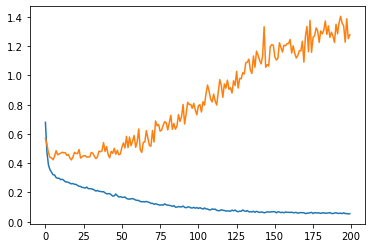

In [45]:
import matplotlib.pyplot as plt

t = torch.load(save_dir/"loss_4.pt")
plt.plot(t["train"])
plt.plot(t["valid"])

0.5731468215066737 0.01181741767800179
0.5384615384615384 -0.033389028164708894
0.5789473684210527 -0.058357285367106965
0.5070332480818414 0.05730937269821193
0.595959595959596 -0.06917144638660747
0.6666666666666667 -0.058823529411764705
0.38580246913580246 -0.1473040805672863
0.41696969696969693 -0.07280937315536447
0.5502354788069074 0.1552930502691702
0.5310344827586206 -0.12917122661105557
0.432093023255814 -0.016772606538118056
0.3885020693836664 -0.15058440063876308
0.8407960199004976 0.23126555068632454
0.5749526525739359 -0.020019607700281935
0.2857142857142857 -0.2182178902359924
0.33333333333333337 -0.16666666666666666
overall AUC: 0.5484139231713097
overall MCC (t=0.1): -0.06965095894974581


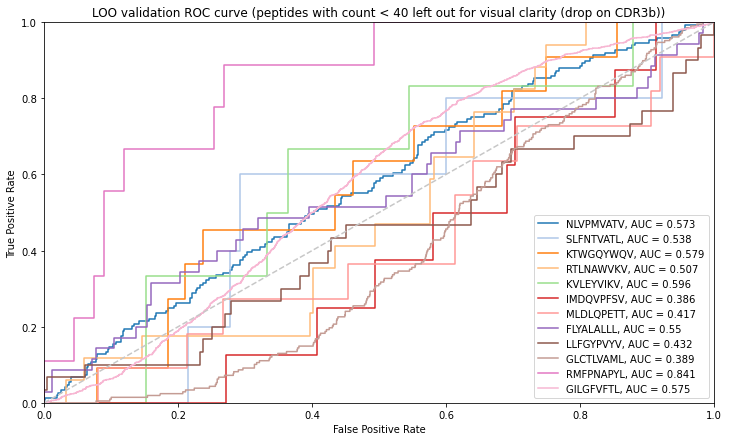

In [33]:
n_splits = len(unique_peptides)
threshold = 0.1

overall_pred = list()
overall_true = list()
overall_thres_pred = list()
# compute metrics
perf_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    pred = data["y_pred"]
    true = data["y_true"]

    # auc
    auc = roc_auc_score(true, pred)
    fpr, tpr, thr = roc_curve(true, pred, pos_label=1)
    
    thresh_pred = torch.zeros(len(pred))
    thresh_pred[pred >= threshold] = 1
    mcc = matthews_corrcoef(true, thresh_pred)
    
    pep = unique_peptides[i]
    perf_data[pep] = [fpr, tpr, auc, mcc]

    print(auc, mcc)

    overall_pred.extend(pred)
    overall_true.extend(true)
    overall_thres_pred.extend(thresh_pred)

print("overall AUC:", roc_auc_score(overall_true, overall_pred))  
print(f"overall MCC (t={threshold}):", matthews_corrcoef(overall_true, overall_thres_pred))

performance_file = save_dir / "performance_data.pt"
torch.save(perf_data, performance_file)

# ROC plot
cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
excluded = ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"] # TODO delete (filter <40 in test set)
for pep in unique_peptides:
    if pep not in excluded:
        ax.plot(
            perf_data[pep][0], 
            perf_data[pep][1], 
            label=f"{pep}, AUC = {round(perf_data[pep][2], 3)}",
        )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOO validation ROC curve (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
plt.show()

In [ ]:
# confusion matrix
labels = ["non-binder", "binder"]
pred_copy = copy.deepcopy(pred)
pred_copy[pred >= 0.2] = 1
pred_copy[pred < 0.2] = 0
cm = confusion_matrix(true, pred_copy)

# f1
f1 = f1_score(true, pred_copy)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plot = disp.plot()
plot.figure_.show()

In [ ]:
fold_idx = 1
data = torch.load(performance_file)[fold_idx]

cm, f1, auc = data["cm"], data["f1"], data["auc"]
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
print(f"LOO performance of fold {fold_idx}:")
print(f"AUC={auc}")
print(f"F1={f1}")

In [12]:
# quick viz
count_dict = dict()
for pep in unique_peptides:
    total = len(metadata[metadata["peptide"] == pep])
    pos = len(metadata[(metadata["peptide"] == pep) & (metadata["binder"] == 1)])
    count_dict[pep] = [total, pos]

In [13]:
count_dict

{'NLVPMVATV': [1217, 149],
 'SLFNTVATL': [70, 5],
 'KTWGQYWQV': [87, 11],
 'RTLNAWVKV': [201, 17],
 'KVLEYVIKV': [39, 6],
 'YLLEMLWRL': [54, 3],
 'IMDQVPFSV': [89, 8],
 'MLDLQPETT': [86, 11],
 'FLYALALLL': [217, 35],
 'SLLMWITQV': [34, 5],
 'LLFGYPVYV': [245, 30],
 'GLCTLVAML': [1667, 208],
 'RMFPNAPYL': [76, 9],
 'GILGFVFTL': [6223, 1311],
 'KLQCVDLHV': [8, 1],
 'KVAELVHFL': [7, 1]}

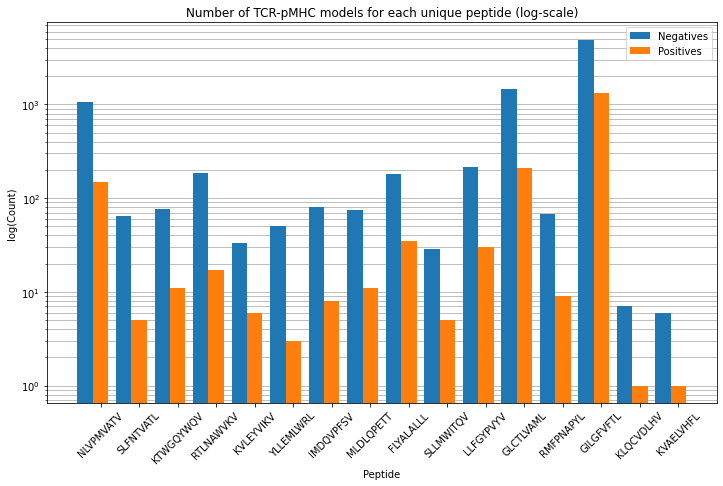

In [66]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

peptides = list(count_dict.keys())
negatives = [x[0] - x[1] for x in count_dict.values()]
positives = [x[1] for x in count_dict.values()]

width = 0.4
idx = np.arange(len(unique_peptides))

ax.bar(idx, negatives, width, zorder=3)
ax.bar(idx + width, positives, width, zorder=3)
ax.set_yscale('log')
ax.set_xticks(idx+width)
ax.set_xticklabels(count_dict.keys(), rotation=45)

ax.grid(zorder=0, which='both', axis='y')

plt.legend(["Negatives", "Positives"])
plt.xlabel("Peptide")
plt.ylabel("log(Count)")
plt.title("Number of TCR-pMHC models for each unique peptide (log-scale)")
plt.show()